# AIR BNB London Notebook EDA


In [4]:
# load initial Libraries
import pandas as pd
import requests
import gzip
from io import BytesIO
import os
import geopandas as gpd
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import plotly.express as px
import json
!pip install langdetect
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import nltk
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
!pip install gender-guesser
import gender_guesser.detector as gender
from collections import Counter
import ast
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np
import math
pd.set_option("display.max_columns",None)
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Download and Extract Data

In [5]:
#Download and extract function
def download_and_extract(url, output_dir="airbnb/"):
  # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Make the request to get the file
    response = requests.get(url)
    response.raise_for_status()

    # Check if the file is gzip-compressed
    is_gzipped = url.endswith(".gz")

    # If it's a .gz file, extract its contents
    if is_gzipped:
        # Use BytesIO to treat the response content as a file-like object
        with gzip.GzipFile(fileobj=BytesIO(response.content), mode="rb") as gz_file:
            # Extracted file name without the .gz extension
            extracted_filename = os.path.join(output_dir, os.path.basename(url)[:-7] + "_full.csv")

            # Write the extracted content to the file
            with open(extracted_filename, "wb") as extracted_file:
                extracted_file.write(gz_file.read())
    else:
        # If it's not a .gz file, save it directly
        downloaded_filename = os.path.join(output_dir, os.path.basename(url))
        with open(downloaded_filename, "wb") as downloaded_file:
            downloaded_file.write(response.content)
        extracted_filename = downloaded_filename

    return extracted_filename


#Download Urls
full_listing = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz"
full_calendar = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/calendar.csv.gz"
full_reviews = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/reviews.csv.gz"
summary_listing = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/visualisations/listings.csv"
summary_reviews = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/visualisations/reviews.csv"
neighborhoods = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/visualisations/neighbourhoods.csv"
neighborhoods_geo = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/visualisations/neighbourhoods.geojson"


#url list
all_files = [full_listing, full_calendar, full_reviews, summary_listing, summary_reviews, neighborhoods, neighborhoods_geo]

#loop for downloading list
for file in all_files:
  download_and_extract(file)

#Read downloaded data
calender=pd.read_csv('airbnb/calendar_full.csv')
listing=pd.read_csv('airbnb/listings.csv')
detailed_listing=pd.read_csv('airbnb/listings_full.csv')
nbhoods=pd.read_csv('airbnb/neighbourhoods.csv')
reviews=pd.read_csv('airbnb/reviews.csv')
detailed_reviews=pd.read_csv('airbnb/reviews_full.csv')
with open('/content/airbnb/neighbourhoods.geojson', 'r') as geojson_file:
    geojson_data = json.load(geojson_file)

<ipython-input-5-79d4bb63e62f>:52: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  listing=pd.read_csv('airbnb/listings.csv')
<ipython-input-5-79d4bb63e62f>:53: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  detailed_listing=pd.read_csv('airbnb/listings_full.csv')


Breif Description of Dataset
Air Bnb is a company operating an online marketplace for short- and long-term homestays and experiences, with operations all over the globe. This data is a representation of airbnb in London dated 2023-09-06 and it has the following tables:

1. calender: contains information regarding availibility of each listing in the future and its price
2. detailed_listing: info for the listing, its host and local neighbourhood
3. listing: filtered columns from detailed listing
4. detailed_reviews: comments from reviews for different listing_id since inception with date
5. reviews: contains just the date and id
6. nbhoods: list of all the neighbourhood in the group
7. nbhoods_geo: list of all the neighbourhood in the group, with longitude and latitude poloygon

We need to derivce some insights that would derive business value.

# Question 1: Are there any generic trends in the data that can be exploited ?

Although the world is moving away from the concept of gender and ethnicity when looking for jobs or in other feild, but it remains an integral part when selecting a temprory accomodation for many individuals.Some individuals may feel more at ease choosing accommodations hosted by individuals of a similar gender, ethnicity, or cultural background, seeking a space where they anticipate shared understanding and potential cultural affinity. This choice often stems from a desire to engage in respectful and culturally enriching experiences, allowing guests to feel more connected and embraced by their temporary living environment.

Other trends might include more values on a particular day of the week or a particular time of month. Since don't have any information regarding customer bookings in the past we will use number of comments as an estimate for the total people coming in any given time, as more the number of people more the number of comments.

Since we don't have any access to gender, we still have access to the name of the person. There are many libraries that can be used to guess the gender based on the name. One such library is gender_gueser.

## Prprocess part

In [ ]:
#remove rows where the reveiwer name is empty and create a copy of the dataframe
detailed_reviews_fp=detailed_reviews[detailed_reviews.reviewer_name.notna()].copy()

# Function to process names - extract the first name, capitalize it, remove punctuation and leading spaces
def process_names(name):
    # Remove leading and trailing spaces
    name = str(name).strip()

    if name and name != 'nan':  # Check if name is not empty or 'nan'
        # Extract the first word as the first name
        first_name = name.split()[0]

        # Capitalize the first letter
        first_name = first_name.capitalize()

        # Remove punctuation
        first_name = re.sub(r'[^\w\s]', '', first_name)

        return first_name
    else:
        return np.nan

#clean reviewer column name in gender guesser
detailed_reviews_fp['reviewer_name'] = detailed_reviews_fp['reviewer_name'].apply(process_names)


#create a gender_guesser object
d = gender.Detector()
#create gender column
detailed_reviews_fp["gender"]=detailed_reviews_fp["reviewer_name"].dropna().apply(lambda x: d.get_gender(f"{x}"))
#make mostly_male as male, mostly_female as female and any other value as unknown
detailed_reviews_fp["gender"]=detailed_reviews_fp["gender"].apply(lambda x: 'male' if x=='mostly_male' else ('female' if x=='mostly_female'
        else('unknown' if x=='andy' else x )))
#repeat above step for getting host gender
detailed_listing["host_name"]=detailed_listing["host_name"].apply(process_names)
detailed_listing["host_gender"]=detailed_listing["host_name"].apply(lambda x: d.get_gender(f"{x}"))
detailed_listing["host_gender"]=detailed_listing["host_gender"].apply(lambda x: 'male' if x=='mostly_male' else ('female' if x=='mostly_female'
        else('unknown' if x=='andy' else x ) ) )
#create a merged dataframe
host_reviewer_gender=pd.merge(detailed_reviews_fp[["listing_id","gender"]],detailed_listing[["id","host_gender","neighbourhood_cleansed"]],left_on="listing_id",right_on="id",how="left")

# Convert date to datetime
detailed_reviews["date"] = pd.to_datetime(detailed_reviews["date"])

# Extract month and year
detailed_reviews["month"] = detailed_reviews["date"].dt.month
detailed_reviews["year"] = detailed_reviews["date"].dt.year

# Group by month and count the number of unique comment IDs
date_by_rev = detailed_reviews.groupby(["year", "month"]).id.nunique().reset_index(name='freq')

# Function to extract the abbreviated day of the week
def get_abbreviated_day_of_week(date):
    return date.strftime('%a')  # %a gives the abbreviated name of the day (e.g., Mon, Tue, Wed)

# Apply the function to extract the abbreviated day of the week
detailed_reviews['abbreviated_day'] = detailed_reviews['date'].apply(get_abbreviated_day_of_week)

print(detailed_reviews)


                 listing_id                  id       date  reviewer_id  \
0                     13913               80770 2010-08-18       177109   
1                     13913              367568 2011-07-11     19835707   
2                     13913              529579 2011-09-13      1110304   
3                     13913              595481 2011-10-03      1216358   
4                     13913              612947 2011-10-09       490840   
...                     ...                 ...        ...          ...   
1581028  971887875299343051  973108321598840305 2023-09-04    532269963   
1581029  970295459665929952  973125058284346062 2023-09-04       814456   
1581030  970371341816641811  972368731470763706 2023-09-03    208891911   
1581031  970371341816641811  973812238966134743 2023-09-05    458483914   
1581032  970392619756691204  973786231321668276 2023-09-05    268096828   

        reviewer_name                                           comments  \
0             Michael  

## Analysis Part

In [ ]:
detailed_listing["host_gender"].value_counts()

female     33996
male       33335
unknown    20615
Name: host_gender, dtype: int64

In [ ]:
detailed_listing[["host_name","host_gender"]].head(10)

host_name host_gender
0       Dee      female
1     Sarah      female
2     Alina      female
3  Philippa      female
4   William        male
5       Liz      female
6    Darshi     unknown
7       Joe        male
8      Carl        male
9     Grace      female

In [ ]:
detailed_reviews_fp["gender"].value_counts()

female     689356
male       630264
unknown    261413
Name: gender, dtype: int64

In [ ]:
detailed_reviews_fp[["reviewer_name","gender"]].head(10)

reviewer_name   gender
0       Michael     male
1       Mathias     male
2       Kristin   female
3       Camilla   female
4         Jorik     male
5          Vera   female
6          Honi  unknown
7    Alessandro     male
8          Oleh     male
9            Mo     male

The gender guesser does have to done its work correctly for most of the cases

In [ ]:
host_reviewer_gender.groupby(["gender","host_gender"]).gender.count()

gender   host_gender
female   female         296802
         male           267060
         unknown        125489
male     female         252371
         male           254076
         unknown        123816
unknown  female         102141
         male           103517
         unknown         55754
Name: gender, dtype: int64

The above dataframe shows what females ares more slightly more likely to choose a female host this could be due to a better sense of security. Although the above information might not be correct as the gender guesser has a lot of unknown genders. Perhaps a more accurate way would be to have the gender filled out in the start when signing up for the app. Also it would be more beneficial to have added more features such as sos alarms, host and customer verification alike in order to improve chances of occupancy

Now lets see the number of customers over time, and whether they are increasing or not

In [ ]:
date_by_freq=detailed_reviews.groupby(["date"]).id.nunique().reset_index(name='freq')
fig = px.scatter(date_by_freq, x="date", y="freq")

# Update layout and display the plot
fig.update_layout(title='Frequency by Date',
                  xaxis_title='Date',
                  yaxis_title='Frequency')
fig.show()

This shows an exponential increase in customers over the years, there is a decrease in the year 2020, most probably due to covid. So as we can see the number of people are increasing exponentialy so lets see what month or day has the most number of people coming in general.

In [ ]:
# Create a histogram
fig = px.bar(date_by_rev, x='month', y = "freq", title='Monthly Frequency Histogram')

# Update layout
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Frequency',
    font=dict(size=12),
    title_font=dict(size=18),
)

# Show the plot
fig.show()

In [ ]:
# Create a histogram
fig = px.bar(date_by_rev, x='month', y = "freq", title='Monthly Frequency Histogram')

# Update layout
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Frequency',
    font=dict(size=12),
    title_font=dict(size=18),
)

# Show the plot
fig.show()

The above graph shows that the monthy of july has the most number of customers coming in. This is peak holiday season, where mostly students and families are off and head out for vacations. Ideally weekends should have the most number of bookings lets see.

In [ ]:
freq_by_day= detailed_reviews.groupby(["abbreviated_day"]).id.nunique().reset_index(name='freq')
# Create a histogram
fig = px.bar(freq_by_day, x='abbreviated_day', y = "freq", title='Day of Week Frequency Histogram')

# Update layout
fig.update_layout(
    xaxis_title='Day',
    yaxis_title='Frequency',
    font=dict(size=12),
    title_font=dict(size=18),
)

# Show the plot
fig.show()

Sunday and Monday, seem to have the highest volume which is expected. However we see that saturday has lower occupancy. What we can do is make some promotional offers on booking Friday,Saturday and Sunday together in order to further increase occupancy on Saturday and deriving revenue.

# Question 2: What percentage of property have more than 50 % percent availibility in the next year?

It would be interesting to see the percetage of properties are booked less than 50 % percent in the next 365 days. And then find out reason for low occupancy rate of certain properties

## Preprocess Part

In [ ]:
#adding numereric column for availibility
calender["date"]=pd.to_datetime(calender["date"])
calender["is_available"]=calender['available'].apply(lambda x: 1 if x=='t' else 0)
# get occupancy rate for each listing id
availibility_rate_df=calender.groupby(["listing_id"]).is_available.mean().reset_index()

## Analysis Part

In [ ]:
print("The percentage of property available over more than 50 percent of the time next year")
round((availibility_rate_df[availibility_rate_df.is_available>0.5]["is_available"].shape[0]/availibility_rate_df.shape[0])*100,2)

The percentage of property available over more than 50 percent of the time next year


31.09

<Axes: xlabel='is_available', ylabel='Density'>

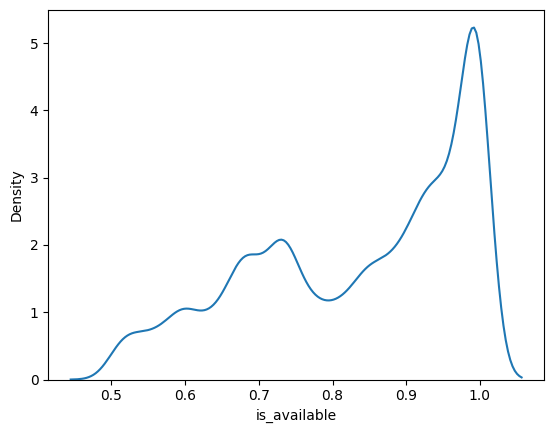

In [ ]:
#see the distribution of these 31.09 % values
sns.kdeplot(availibility_rate_df[availibility_rate_df.is_available>0.5]["is_available"])

31.09 % have availibility of more than 50% for the entire year, out of these 31.09 % majority are situated from 80% to 100 %.

# Question:3 what could be the possible reason for low occupancy ?

## Pre Process

In [ ]:
#get the listing ids for availibility rate greater than 80%
low_occupancy_id=list(availibility_rate_df[availibility_rate_df.is_available>0.8].listing_id.unique())
detailed_listing["is_low_occupied"]=detailed_listing.id.apply(lambda x: 1 if x in low_occupancy_id else 0)
#Handling price value for
#function to convert string in list form to actual list
def convert_to_list(amenities_str):
    return ast.literal_eval(amenities_str)
#remove the dollar sign from price
detailed_listing['price'] = detailed_listing['price'].replace('[\$,]', '', regex=True).astype(float)

detailed_listing["amenities"]=detailed_listing["amenities"].apply(convert_to_list)
low_occupancy_df=detailed_listing[detailed_listing.is_low_occupied==1].copy()
high_occupancy_df=detailed_listing[detailed_listing.is_low_occupied==0].copy()

## Analysis Part

Price can be one of the factor for low occupancy lets see if this is true

In [ ]:
detailed_listing.groupby(["is_low_occupied"]).price.mean()

is_low_occupied
0    167.651633
1    239.582637
Name: price, dtype: float64

As we can see that price for the low occupied is higher than the more occupied. Price range can be an important factor, cheaper places will get booked earlier than expensive ones,One more import factor would be to check avg accommodations the listing can handle

In [ ]:
detailed_listing.groupby(["is_low_occupied"]).accommodates.mean()

is_low_occupied
0    3.130369
1    3.314246
Name: accommodates, dtype: float64

Not much of a difference, here. Another factor could be that avg score rating

In [ ]:
detailed_listing.groupby(["is_low_occupied"]).review_scores_rating.mean()

is_low_occupied
0    4.609317
1    4.540788
Name: review_scores_rating, dtype: float64

Not much of a difference here either, the less occupied seem to have a slightly lower rating but nothing that would be very impactful, perhaps there are some amenities which are present in the higher occupancy but not present in the lower occupancy listings or present in more quantities,specially for cases that have lower than the mean price of low occupany listing

Text(0.5, 1.0, 'price distribution of low occupancy')

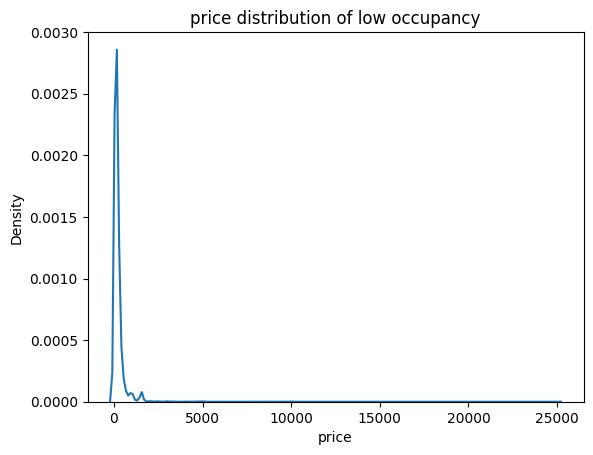

In [ ]:
# First we see the distribution price distribution of low occupancy df
sns.kdeplot(low_occupancy_df.price)
plt.title("price distribution of low occupancy")

We see that majority of the values are situated around 180 to 200, but there are quite a few outliers that are skewing the mean and its highly unlikely that they will have such high values, this seems to be a problem in the data so lets set a cap to of 1500 to wherever the price is exceeding 1500.

This also shows that although its true that high price values are there but its not the only reason for low occupancy.

Text(0.5, 1.0, 'price distribution for low occupancy with cap of 1000')

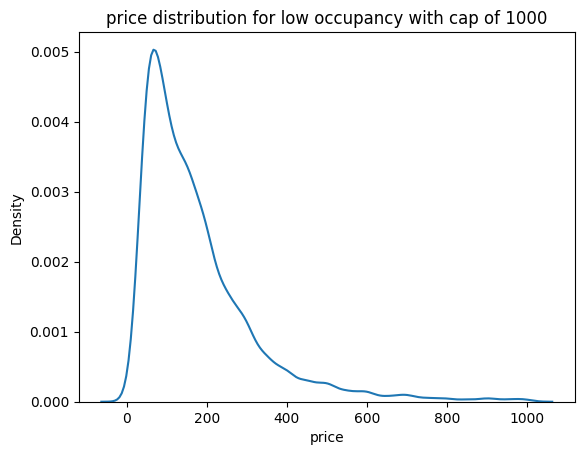

In [74]:
detailed_listing["price"]=detailed_listing["price"].apply(lambda x: 1500 if x>1500 else x)
#lets set a cap on the max price
sns.kdeplot(low_occupancy_df[low_occupancy_df.price<1000].price)
plt.title("price distribution for low occupancy with cap of 1000")

In [ ]:
print("Percentage of low occupancy with mean price less than 230 is")
round(low_occupancy_df[low_occupancy_df.price<230].shape[0]*100/low_occupancy_df.shape[0],2)

Percentage of low occupancy with mean price less than 230 is


72.71

Now going forward lets check the amenties present in the high occupancy listings but not in the low occupancy listing which have lower price than then mean low occupancy price.

In [ ]:
all_amenities_high_occupancy = [amenity.strip('"') for amenities_list in high_occupancy_df["amenities"] for amenity in amenities_list]
all_amenities_low_occupancy = [amenity.strip('"') for amenities_list in low_occupancy_df[low_occupancy_df.price<230]["amenities"] for amenity in amenities_list]
word_frequency_high = Counter(all_amenities_high_occupancy)
word_frequency_low= Counter(all_amenities_low_occupancy)
word_freq_df_high = pd.DataFrame(list(word_frequency_high.items()), columns=['Word', 'Frequency'])
word_freq_df_low = pd.DataFrame(list(word_frequency_low.items()), columns=['Word', 'Frequency'])
word_freq_df_high["percentage"]=word_freq_df_high["Frequency"]/high_occupancy_df.shape[0]
word_freq_df_low["percentage"]=word_freq_df_low["Frequency"]/low_occupancy_df.shape[0]
top_amenities=pd.merge(word_freq_df_high,word_freq_df_low,on="Word",how="left",suffixes=("_high","_low"))
top_amenities["diff"]=top_amenities["percentage_high"]-top_amenities["percentage_low"]

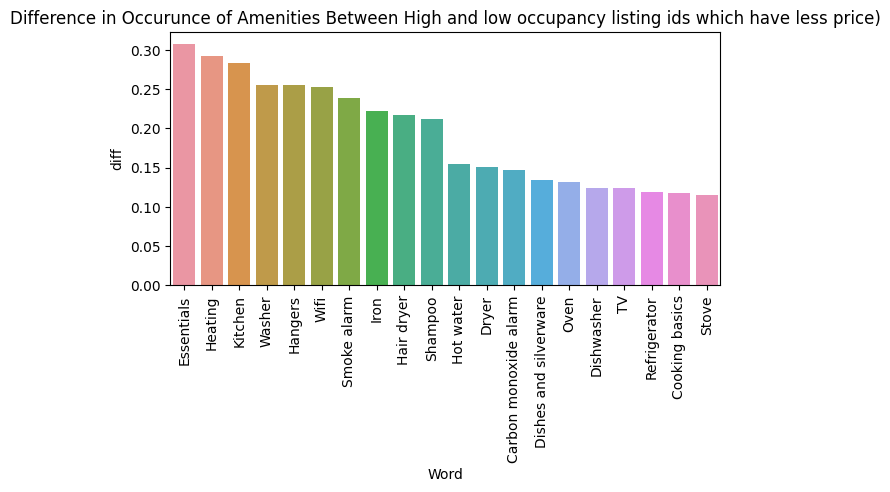

In [ ]:
sns.barplot(data=top_amenities.sort_values(by="diff",ascending=False).head(20),x="Word",y="diff")
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.title("Difference in Occurunce of Amenities Between High and low occupancy listing ids which have less price)")
plt.show()

We can see  from the above graph that some of the essential commodities such as heating are missing from the amenities of low occupancy listing with low price, either they forgot to mention. It is essential that comodities be provicded in order to faciliate stay and increase occupancy rate. This can be suggested to the host.

# Question 4: What is the total number of unique neighbour and which is the most densly populated area ?

##preprocess

In [75]:
#preprocessing
print(detailed_listing.id.isnull().sum())
print(detailed_listing.neighbourhood_cleansed.isnull().sum())
#both dont have any null value
#creating frame with number of listing for each neighbourhood
count_listing_nb=detailed_listing.groupby("neighbourhood_cleansed").id.nunique().reset_index(name="number_of_listings").sort_values(by='number_of_listings')

0
0


## Analysis

In [76]:
fig = px.bar(
    count_listing_nb,
    x='neighbourhood_cleansed',
    y='number_of_listings',
    labels={'neighbourhood_cleansed': 'neighbourhood_cleansed', 'number_of_listings': 'number_of_listings'},
    title='Number of Listings in Each Neighborhood'
)

fig.update_layout(
    xaxis_title='Neighborhood',
    yaxis_title='Number of Listings'
)

fig.show()

print(f"total number of neighourbour hoods are: {str(count_listing_nb.neighbourhood_cleansed.nunique())}")

total number of neighourbour hoods are: 33


Total Number of neighbourhoods are 33, with westminister being the most populated one. It would be interesting to see how the price and rating vary with respect to the geographic location.

# Question 5: What is the highest average price on a neighbourhood?

In [77]:
#preprocess part
avg_price_per_nb=detailed_listing.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
#create variable of per person price
detailed_listing["price_per_person"]=detailed_listing["price"]/detailed_listing["accommodates"]
avg_price_per_person_nb=detailed_listing.groupby('neighbourhood_cleansed')['price_per_person'].mean().reset_index()


In [78]:
# average neighborhood price overlaed on a map

fig = px.choropleth_mapbox(
    avg_price_per_nb,
    geojson=geojson_data,
    locations='neighbourhood_cleansed',
    featureidkey="properties.neighbourhood",
    color='price',
    color_continuous_scale="Viridis",
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": detailed_listing['latitude'].mean(), "lon": detailed_listing['longitude'].mean()},
    opacity=0.5,
    labels={'price': 'Average Price'},
    title='Average Price per Neighborhood'
)

fig.update_layout(coloraxis_colorbar=dict(title='Average Price'))

fig.show()

The highest mean price is of 299.5 and the lowest being 89.9, this neighbour hood is called Westminister and it kind of makes sense as well since this is central London, however there is another column appearing in the dataframe which shows the number of person each listing can accomodate, it would be interesting to see what impact the per person price has.

In [80]:
# average neighborhood price per person overlaed on a map

fig = px.choropleth_mapbox(
    avg_price_per_person_nb,
    geojson=geojson_data,
    locations='neighbourhood_cleansed',
    featureidkey="properties.neighbourhood",
    color='price_per_person',
    color_continuous_scale="Viridis",
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": detailed_listing['latitude'].mean(), "lon": detailed_listing['longitude'].mean()},
    opacity=0.5,
    labels={'price_per_person': 'Average Price per person'},
    title='Average Price per person per Neighborhood'
)

fig.update_layout(coloraxis_colorbar=dict(title='Average Price per person'))

fig.show()

The highest mean price per person is 97.2, of Hounslow

# Question 6: What is the avg lowest rating on a neighbhour hood ?

## Preprocess

In [ ]:
#pre process
#create dataframe for avg rating
avg_rating=detailed_listing.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().reset_index()

## Analysis

In [ ]:

fig = px.choropleth_mapbox(
    avg_rating,
    geojson=geojson_data,
    locations='neighbourhood_cleansed',
    featureidkey="properties.neighbourhood",
    color='review_scores_rating',
    color_continuous_scale="Viridis",
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": detailed_listing['latitude'].mean(), "lon": detailed_listing['longitude'].mean()},
    opacity=0.5,
    labels={'review_scores_rating': 'review_scores_rating'},
    title='review_scores_rating per Neighborhood'
)

fig.update_layout(coloraxis_colorbar=dict(title='Average rating'))

fig.show()

The lowest avg rating is of 4.49 of Hillingdon, mostly the average rating is above 4.5, maybe this is because houses in london are generally nicer compared to other cities. "Kingston upon Thames" has the highest rating but the prices aren't that high, so its a good spot to increase promotional offers and increase revenue. Previously we computed the highest avg price per person which is "Hounslow" it has a relatively one of the lowest ratings. However 4.5 is still good, it would be more beneficial to see the percentage of listings that fall below 3.5 or 3 and identify what is the main reason behind this. Moreover we see that prices of west minister dropped which indicates that it has houses with higher rents but more people can be accomodate.

# Question 7: Reasons for low rating and whether they can be improved ?

Since we have the comment section since inception its bound to be filled with a heap of information as to what is wrong with these locations. However the comment section is also filled with jargon, non english comments and it would be better to remove them. So as to get a visual representation as to what kind of words are being used in the comment section we will build word clouds. Word clouds take the frequency of word and return a beautiful visual, with the size of the word coresponding to the frequency of use.

In [81]:
#give low rated flag
detailed_listing["is_low_rated"]=detailed_listing["review_scores_rating"].apply(lambda x: 1 if x<3.5 else 0)
print("ratio of low rated properties with less than 3.5 rating are :", detailed_listing["is_low_rated"].mean())
#first use langdetect library to remove non english comments
low_score_ids=low_rating_scores_id=list(detailed_listing[detailed_listing.is_low_rated==1].id.unique())
#filter out comments that belong to these listing_ids
low_score_reviews=detailed_reviews[detailed_reviews.listing_id.isin(low_score_ids)].copy()

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return "Unknown"

#dectect language in these reviews and filter out english commends
low_score_reviews["language"]=low_score_reviews["comments"].apply(detect_language)
low_score_reviews=low_score_reviews[(low_score_reviews.language=='en') & low_score_reviews.comments.notna()].copy()
print(low_score_reviews.shape)

ratio of low rated properties with less than 3.5 rating are : 0.03253132604097969
(4489, 10)


so we have 4488 unique reviews about the these listing ids, now for building the word cloud

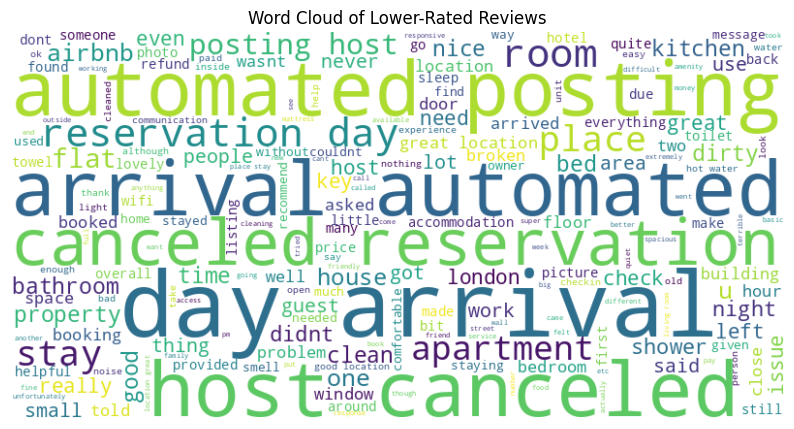

In [82]:
def preprocess_text(text):

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Convert text to lowercase
    text = text.lower()


     # Remove special characters and numbers, except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text


#convert comments to list form
low_rated_comments_list=low_score_reviews.comments.to_list()
lower_rated_corpus = ' '.join(low_rated_comments_list)
lr_cm_processed=preprocess_text(lower_rated_corpus)


# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(lr_cm_processed)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Lower-Rated Reviews')
plt.show()

As we can see the last minute cancelation by host is the biggest factor of low rating. Proper communication channels should be in place so that last minute cancellation can be avoided. Other such factors that decrease rating include cleanlinessless, dirty bedrooms or bathrooms. This can be suggested to host in order to improve rating and occupancy thus deriving more revenue. However there are words like good as well in the word cloud. Do the comments reflect on the review_rating_scores ?

# Question 8: Is the influx of customer over the last year corelated to factor such as the description and completeness of profile ?



Factors such as the lenght of the description and certain key words play an important role in increasing the influx of customers. People are more likely to be attraced to a good profile with both the description about the host and details about the house such as pictures and stuff.

## Pre Process Part

In [83]:
#get the lenght of the description of each listing, ideally a better description would have a higher length
detailed_listing["length"]=detailed_listing.description.astype(str).apply(lambda x: len(x))
#get max lenghth
max_length=detailed_listing["length"].max()
#create 5 buckets where 1 represets 0-200, 2 represents 201-400 and so on when 5 represents 801-1000
detailed_listing["description_lenght_bucket"]=detailed_listing["length"].apply(lambda x: math.ceil(x*5/max_length))

## Analysis

<Axes: xlabel='length', ylabel='Density'>

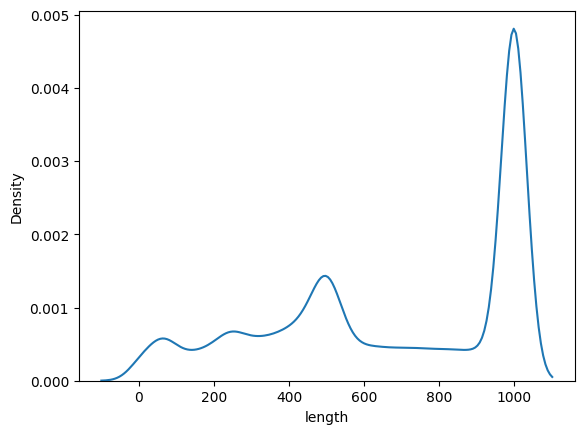

In [84]:
#distribution of lengths
sns.kdeplot(detailed_listing.length)

In [ ]:
print(str(round(detailed_listing[detailed_listing.length==1000].shape[0]*100/detailed_listing.shape[0],2)) + "%: hosts have utilised full lenght of the description given" )

38.79%: hosts have utilised full lenght of the description given


Mostly are situated around 1000

Text(0.5, 1.0, 'Number of reviews received in the last year vs description lenght bucket')

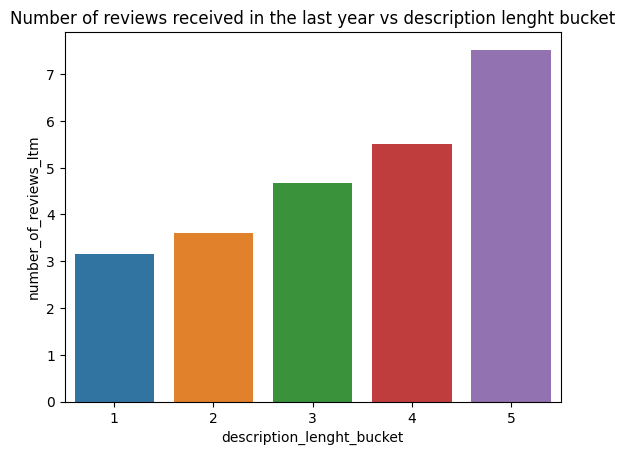

In [ ]:
# computer avg reviews received in the last year for each of the length buckets
fig,ax=plt.subplots()
avg_num_revs_lst=detailed_listing.groupby("description_lenght_bucket").number_of_reviews_ltm.mean().reset_index()
sns.barplot(avg_num_revs_lst,x="description_lenght_bucket",y="number_of_reviews_ltm")
plt.title("Number of reviews received in the last year vs description lenght bucket")

From the above bar plot we can see that the length of the description plays a vital role in attracting customers. So we can ask customers to write better descriptions of what they have or provide them with proper guidelines on how to describe their bnb. We can use word clouds based on descriptions that received highest reviews to help us identify keywords that are more likely to attrac customers.

(3964, 82)


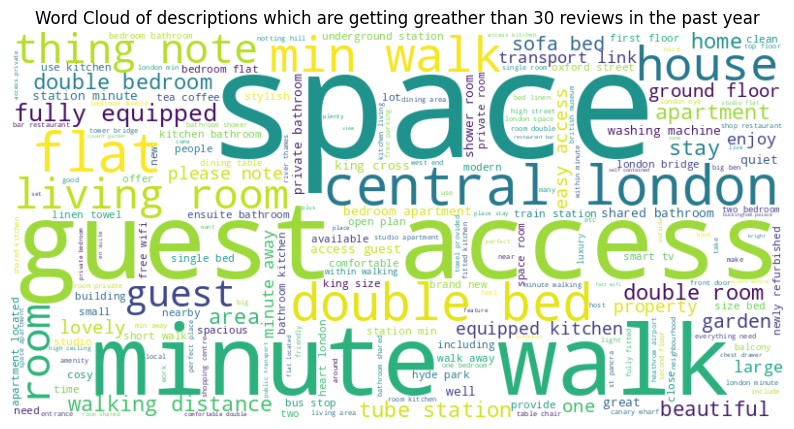

In [ ]:
#create a subset of the dataframe for greater than 30 reviews in the past year
greater_than_30=detailed_listing[detailed_listing.number_of_reviews_ltm>30].copy()
print(greater_than_30.shape)
greater_than_30_description=greater_than_30["description"].astype(str).to_list()
greather_than_30_corpus = ''.join(greater_than_30_description)
greater_than_30_processed=preprocess_text(greather_than_30_corpus)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(greater_than_30_processed)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of descriptions which are getting greather than 30 reviews in the past year')
plt.show()

From the above word cloud it is essential to see that when writing the description it is important to tell about the space as to what kind of a place it is , it is important to tell about the distance from important places such as supermarkets,places of worship, parks, station, airports, subway. It is also important to tell about the amenities that come with the apartment and the type of furniture as these are taken into consideration when choosing an airbnb

In [ ]:
# How many of the hosts have their identity verified
detailed_listing.host_identity_verified.value_counts()

t    76792
f    11149
Name: host_identity_verified, dtype: int64

From the above results we can see that majority of the hosts have their identity verified, lets see what impact does this have on the number of reviews received in the last year. Remember the number of reviews is propotional to the number of customers that are coming in.

Text(0.5, 1.0, 'Number of reviews received in the last year vs profile verification')

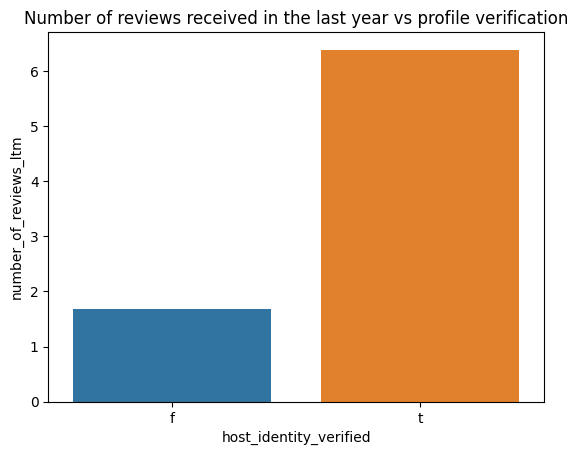

In [ ]:
#Get the average number of reviews in the last year for hosts that verified themselfs and hosts that didfnt verify
reviews_by_verification=detailed_listing.groupby("host_identity_verified").number_of_reviews_ltm.mean().reset_index()
sns.barplot(reviews_by_verification,x="host_identity_verified",y="number_of_reviews_ltm")
plt.title("Number of reviews received in the last year vs profile verification")

This clearly shows that profile verifications plays an instrumental role in attracting customers, as customers are more likely not to feel safe if the profile is not verified.

# Question 9: What percentage of listing have lower than 75 percentage acceptance rate ?

## Preprocess Part

In [ ]:
#remove percentage sign and convert to float from host acceptance rate
detailed_listing['host_acceptance_rate'] = detailed_listing['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)
#create low acceptance flag
detailed_listing["is_low_acceptance"]=detailed_listing.host_acceptance_rate.apply(lambda x: 1 if x<75 else 0)

## Analysis Part

In [ ]:
print("The percentage of host with acceptance rate less than 75 is:")
round(detailed_listing.is_low_acceptance.mean()*100,2)

The percentage of host with acceptance rate less than 75 is:


15.46

We would like to see what kind of customer the host with low acceptances is likely to give booking to through the comment section and whether they are more likely to accept people who are old customers and that have higher price range in past.

# Question 10: What is overall mean average price the person is willing to payand mean frequency of booking in the past of reveiwer ids that were accepted by the low acceptance host and of those who didn't stay with the low acceptance host ?

## Preprocess Part

From the past experience of the customer and the listings he has visited we will calculate the mean price and that is the customers price range or the money he is willing to pay.
Frequency here is the total number of booking he has made in the past

In [ ]:
#merge detailed reviews and detailed listings to get info about the mean price of booking a customer has made
detailed_reviews_2=pd.merge(detailed_reviews,detailed_listing[["id","neighbourhood_cleansed","price","accommodates",'is_low_acceptance']],left_on="listing_id",right_on="id",how="left")
#Build a crm that will contain info regarding the the avg mean price customer is willing to pay, the avg accomodation size the person is has booked, and the fequency with which they have booked
crm=detailed_reviews_2.groupby(["reviewer_id"]).agg(willingness_to_pay=("price","mean"),No_booking_in_the_past=("id_x","count"),family_size=("accommodates","mean")).reset_index()
is_low_accenptance_id=list(detailed_reviews_2[detailed_reviews_2.is_low_acceptance==1].reviewer_id.unique())
is_high_accenptance_id=list(detailed_reviews_2[detailed_reviews_2.is_low_acceptance==0].reviewer_id.unique())

## Analysis Part

In [ ]:
#Filter out the reviewer ids that were accepted by the low acceptance and see the mean price they have paid in the past and the mean frequency which they have previously booked
print("The mean price the customer accepted by the low acceptance host is willing to pay and the frequency of past stays is")
print(crm[crm.reviewer_id.isin(is_low_accenptance_id)].agg({'No_booking_in_the_past':'mean','willingness_to_pay':'mean'}))
#Filter out the reviewer ids that were not accepted by the low acceptance and see the mean price they have paid in the past and the mean frequency which they have previously booked
print("The mean price the customer not accepted by the low acceptance host is willing to pay and the frequency of past stays is")
print(crm[crm.reviewer_id.isin(is_high_accenptance_id)].agg({'No_booking_in_the_past':'mean','willingness_to_pay':'mean'}))

The mean price the customer accepted by the low acceptance host is willing to pay and the frequency of past stays is
No_booking_in_the_past      1.458610
willingness_to_pay        172.893555
dtype: float64
The mean price the customer not accepted by the low acceptance host is willing to pay and the frequency of past stays is
No_booking_in_the_past      1.197779
willingness_to_pay        138.332985
dtype: float64


we can see clearly from this the host with low acceptance rate is more likely to accept people with who have previous records of booking in the past and have a higher mean price they are willing to pay than those that were not accepted. In order to increase acceptance we can pair hosts with customers that have already booked in the past and have higher price range.

# Conclusion

Special days and time should be taken into consideration from promotional deals in order to maximise revenue for example sundays tend to have more influx of customers as compared to saturday, so it would be beneficial to have promotional offers that would give discount on booking both saturdays and sundays. Moreover factors such as verification, proper description play major role when attracting customers so its important both of them are properly setup. Also it is important to have normal commodities such as heating installed in the homes since london is generally cold and people wont stay in places without heating. Moreover people also need places to clean their clothes and cook so its important to have a washing machine and cooking utensils, also most people still work while on holidays so its very important to have a wifi setup. Moreover last minute cancellation should be avoided, most of the places with low rating had last minute cancelations in them, so its important to have a proper cancellation policy in place in order to avoid this. Further more in order to increase acceptance rate for certain hosts it is important that they location, price range,gender prefrence be taken into account when building a recommender system. The following is a reommender system, I have built for the following problem

# word2vec based recomender system

This recommender system leverages Word2Vec, a popular word embedding technique, to provide personalized Airbnb listing recommendations for users based on their past reviews. The system combines information from both listing details and reviewer comments to create a comprehensive representation of the user's preferences.

The following steps to preprocess text are used:

- Listings and reviews data are loaded and combined.
- Relevant text information, including listing names, descriptions, host about sections, and reviewer comments, is concatenated.
- The combined text is preprocessed, including steps such as lowercase conversion, HTML tag removal, and tokenization.

In [6]:
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers, except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

# Example usage
example_text = "<b>The space</b><br />Hi everyone! I have 2 rooms with twin beds for people..."
processed_example = preprocess_text(example_text)
print(processed_example)



['space', 'hi', 'everyone', 'room', 'twin', 'bed', 'people']


In [7]:
from tqdm import tqdm

tqdm.pandas()

# Combine relevant information
combined_data = pd.merge(detailed_reviews, detailed_listing, left_on='listing_id', right_on='id', how='left')
combined_data['combined_text'] = combined_data['name'] + ' ' + combined_data['description'] + ' ' + combined_data['host_about'] + ' ' + combined_data['comments']
#only keeping 100000 samples due to memory constraints
combined_data = combined_data.dropna(subset = 'combined_text').sample(100000)

combined_data['combined_text'] = combined_data['combined_text'].progress_apply(preprocess_text)
combined_data.head(3)

100%|██████████| 100000/100000 [03:34<00:00, 465.79it/s]


listing_id                id_x        date  reviewer_id reviewer_name  \
844819    25875591           348539044  2018-11-14    193195883         Mihai   
529696    15446276  882489569236048213  2023-05-02    455995344     Dominique   
778212    22863245  836165933199216235  2023-02-27     30772922           Eve   

                                                 comments        id_y  \
844819  A very nice home with communicative and hospit...  25875591.0   
529696  Beste Eduardo,<br/>Wij hebben een heerlijke ti...  15446276.0   
778212  Love it! We had a week stay at Ilmari, Co host...  22863245.0   

                                  listing_url     scrape_id last_scraped  \
844819  https://www.airbnb.com/rooms/25875591  2.023091e+13   2023-09-07   
529696  https://www.airbnb.com/rooms/15446276  2.023091e+13   2023-09-06   
778212  https://www.airbnb.com/rooms/22863245  2.023091e+13   2023-09-06   

                 source                                               name  \
844819      city scrape  Townhouse in Greater London · ★4.77 · 1 bedroo...   
529696  previous scrape  Rental unit in London · ★4.51 · 2 bedrooms · 2...   
778212      city scrape  Rental unit in London · ★4.69 · 1 bedroom · 1 ...   

                                              description  \
844819  Please note that only the bedroom is rented ou...   
529696  REFURBISHED APRIL 2023: Feedback from older re...   
778212  Looking for a convenient, bright double en sui...   

                                    neighborhood_overview  \
844819  My neighbours are great and the place is relat...   
529696  Custom House is well connected and easy to rea...   
778212  A lovely, leafy neighbourhood by the Regents C...   

                                              picture_url      host_id  \
844819  https://a0.muscache.com/pictures/c91ad16c-402e...  194427388.0   
529696  https://a0.muscache.com/pictures/f8432680-573b...   18371977.0   
778212  https://a0.muscache.com/pictures/ab76735b-bd69...  140240020.0   

                                           host_url host_name  host_since  \
844819  https://www.airbnb.com/users/show/194427388     Hadja  2018-06-09   
529696   https://www.airbnb.com/users/show/18371977   Eduardo  2014-07-19   
778212  https://www.airbnb.com/users/show/140240020    Ilmari  2017-07-13   

                 host_location  \
844819  London, United Kingdom   
529696         Valencia, Spain   
778212  London, United Kingdom   

                                               host_about  host_response_time  \
844819  Easy going, love to socialise, very curious ab...  within a few hours   
529696  Online Trader and property manager (to pay the...  within a few hours   
778212  As a host, I am supportive, friendly and respe...      within an hour   

       host_response_rate host_acceptance_rate host_is_superhost  \
844819               100%                 100%                 f   
529696               100%                  93%                 f   
778212               100%                  94%                 f   

                                       host_thumbnail_url  \
844819  https://a0.muscache.com/im/pictures/user/40833...   
529696  https://a0.muscache.com/im/users/18371977/prof...   
778212  https://a0.muscache.com/im/pictures/user/15911...   

                                         host_picture_url host_neighbourhood  \
844819  https://a0.muscache.com/im/pictures/user/40833...          Greenwich   
529696  https://a0.muscache.com/im/users/18371977/prof...                NaN   
778212  https://a0.muscache.com/im/pictures/user/15911...         Haggerston   

        host_listings_count  host_total_listings_count  \
844819                  1.0                        1.0   
529696                  4.0                        9.0   
778212                  2.0                        3.0   

                      host_verifications host_has_profile_pic  \
844819                ['email', 'phone']                    t   
529696  ['em

Word Embedding (Word2Vec):
- Tokenized text is used to train a Word2Vec model, which captures semantic relationships between words.
- Each word is represented as a dense vector in a continuous vector space.

Feature Extraction:
- For each listing and reviewer, the average vector of its constituent words is calculated.
- This results in numerical vectors representing the textual information of each listing and reviewer.

Similarity Calculation:
- Cosine similarity is used to measure the similarity between the reviewer's past reviews and each listing.
- Higher similarity scores indicate listings that align closely with the reviewer's preferences.


In the example, recommendations are demonstrated for a single reviewer. In a real-world setting, the system can be scaled to accommodate multiple reviewers. Each reviewer's preferences contribute to the overall knowledge base, creating a more diverse and accurate recommendation model.



In [8]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# build word2vec based recommendation system prototype
combined_data['combined_text'] = combined_data['combined_text'].progress_apply(lambda x: word_tokenize(str(x)))

# Tokenized text
tokenized_text = combined_data['combined_text']
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

def get_vector(text):
    # Calculate the average vector for the given text
    vectors = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * 100  # Return a vector of zeros for missing text

combined_data['vector'] = combined_data['combined_text'].apply(get_vector)

# Similarity Calculation
def calculate_similarity(vector1, vector2):
    return cosine_similarity([vector1], [vector2])[0][0]

100%|██████████| 100000/100000 [03:10<00:00, 526.00it/s]


In [9]:
combined_data.to_csv("combined.csv")

In [10]:
# vectorise the listing data
detailed_listing = detailed_listing.loc[detailed_listing.id.isin(combined_data.listing_id)]
detailed_listing['combined_text'] = detailed_listing['name'] + ' ' + detailed_listing['description'] + ' ' + detailed_listing['host_about']
detailed_listing['combined_text'] = detailed_listing['combined_text'].progress_apply(preprocess_text)
detailed_listing['vector'] = detailed_listing['combined_text'].progress_apply(get_vector)

100%|██████████| 21638/21638 [00:02<00:00, 8407.51it/s] 


In [11]:
# Choose a reviewer and get their past reviews - random reviewer
reviewer_reviews = combined_data[combined_data['reviewer_id'] == combined_data['reviewer_id'].sample(n=1).iloc[0]]['vector'].tolist()[0]

# Rank Listings based on Similarity
detailed_listing['similarity_score'] = detailed_listing['vector'].apply(lambda x: calculate_similarity(x, reviewer_reviews))

# Rank listings based on similarity score
recommended_listings = detailed_listing.sort_values(by='similarity_score', ascending=False)[['id', 'similarity_score', 'name']]

# Display recommended listings
print(recommended_listings)

                       id  similarity_score  \
3552              4819825          0.273174   
33624            35642302          0.271504   
58272  708462190672614965          0.271504   
23305            23448945          0.271504   
47228            52727031          0.271504   
...                   ...               ...   
3155              4223888         -0.165386   
3148              4361078         -0.165386   
30324            31533142         -0.165386   
51993  617431298322321404         -0.169035   
51990  617431178411159065         -0.169035   

                                                    name  
3552   Rental unit in London · ★4.73 · 2 bedrooms · 2...  
33624  Condo in Greater London · ★4.68 · 1 bedroom · ...  
58272  Home in Greater London · ★4.67 · 1 bedroom · 1...  
23305  Rental unit in Greater London · ★4.89 · 2 bedr...  
47228  Rental unit in  London · ★4.08 · 1 bedroom · 2...  
...                                                  ...  
3155   Home in London 

Possible Reasons for Lower Similarity:

- Limited Training Data: The Word2Vec model is trained on a limited dataset. If the training data is not representative of the entire range of language used in reviews and listings, it may result in lower similarity scores.

- Review Quality: The quality of reviews can impact similarity scores. If reviews are sparse, noisy, or not representative of the actual experience, it can affect the accuracy of the Word2Vec model.

- Features used are a small subset of all possible features for the recommender model. For example, quantitative features such as geographical location, listing rating and host traits could be added as features to improve the recommendations of the model.

Potential Next Steps:

- Model Fine-Tuning: Experiment with different hyperparameters for the Word2Vec model, such as vector size, window size, and minimum count. Fine-tuning these parameters might improve the model's ability to capture semantic relationships.

- Data Augmentation: We may consider augmenting the training data with more reviews and listings to enhance the model's understanding of the language used in the domain.

- Alternative Models: Explore alternative embedding models or techniques, such as doc2vec or transformer-based models, which might capture more complex relationships in the data.

- Evaluation Metrics: Introduce evaluation metrics to assess the performance of the recommender system, such as precision, recall, or F1 score, to better understand its effectiveness.


User Feedback Loop:

- Incorporate user feedback to iteratively improve the recommender system. Collect feedback from users about the relevance of recommended listings and use it to refine the model.